[Getting Started](https://pystan.readthedocs.io/en/latest/getting_started.html)と
[Python（PyStan）で「StanとRでベイズ統計モデリング」の5.1節を実行する](http://statmodeling.hatenablog.com/entry/pystan-rstanbook-chap5-1) を参考にChap.4をPythonで実行してみる

In [151]:
import pandas as pd
import numpy as np
import pystan
import matplotlib.pyplot as plt
%matplotlib inline

## 4.4 単回帰
データファイル読み込み

In [152]:
df_salary = pd.read_csv('input/data-salary.txt')
data_salary = df_salary.to_dict('list')
data_salary['N'] = len(df_salary)
#data_salary

### 4.4.2 データの分布の確認

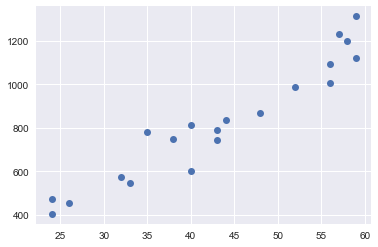

In [153]:
plt.plot(data_salary['X'], data_salary['Y'], "o")

線形回帰は省略

### 4.4.5 Stanで実装

モデルは文字列で与えれば良い

In [154]:
model_4_5 = """
data {
  int N;
  real X[N];
  real Y[N];
}

parameters {
  real a;
  real b;
  real<lower=0> sigma;
}

model {
  for (n in 1:N) {
    Y[n] ~ normal(a + b*X[n], sigma);
  }
}
"""

In [155]:
fit = pystan.stan(model_code=model_4_5, data=data_salary, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_aab1f1627b3096147fe8a6201e709621 NOW.


結果のサマリー

In [156]:
print(fit)

Inference for Stan model: anon_model_aab1f1627b3096147fe8a6201e709621.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a     -115.8    3.52  74.42 -257.9 -165.5 -117.5 -66.38  30.89    446   1.01
b      21.82    0.08   1.65   18.5  20.73  21.82  22.93  24.93    442   1.01
sigma  85.03    0.55  15.46  61.42  73.82  82.74  93.37 122.61    779    1.0
lp__  -93.59    0.05   1.25 -96.77 -94.18 -93.29 -92.68 -92.14    573    1.0

Samples were drawn using NUTS at Tue Mar 21 15:36:23 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


収束状況のプロット

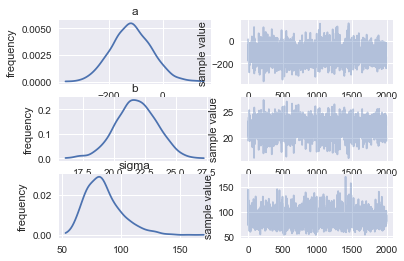

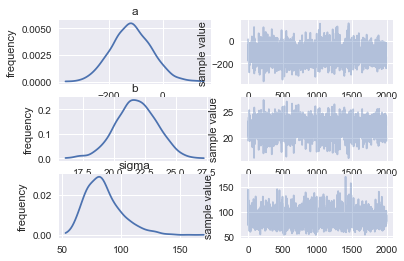

In [157]:
fit.plot()

### 4.4.11 ベイズ信頼区間とベイズ予測区間の算出

95%ベイズ信頼期間は `np.percentile` を使って算出できる

In [158]:
la = fit.extract(permuted=True)  # return a dictionary of arrays
print(len(la['a']))
print(np.percentile(la['a'], [2.5, 97.5]))
print(np.percentile(la['b'], [2.5, 97.5]))
print(np.percentile(la['sigma'], [2.5, 97.5]))      

2000
[-257.82964068   30.55999501]
[ 18.50509749  24.92345435]
[  61.43969018  122.58687629]


周辺分布は seaborn を使えば出せる

In [159]:
df = pd.DataFrame()
df['a'] = la['a']
df['b'] = la['b']
#df

/Users/takashi_miyamoto/.pyenv/versions/anaconda3-2.1.0/lib/python3.4/site-packages/matplotlib/__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


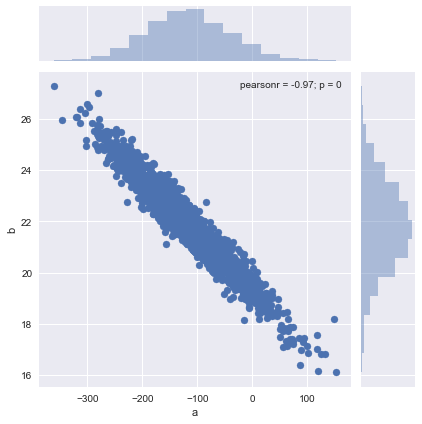

In [160]:
import seaborn as sns
sns.jointplot(x='a', y='b', data=df, marginal_kws=dict(bins=15))

### 4.4.12 transformed parametersブロックとgenerated quantitiesブロック

In [161]:
model_4_4 = """
data {
  int N;
  real X[N];
  real Y[N];
  int N_new;
  real X_new[N_new];
}

parameters {
  real a;
  real b;
  real<lower=0> sigma;
}

transformed parameters {
  real y_base[N];
  for (n in 1:N)
    y_base[n] = a + b*X[n];
}

model {
  for (n in 1:N)
    Y[n] ~ normal(y_base[n], sigma);
}

generated quantities {
  real y_base_new[N_new];
  real y_new[N_new];
  for (n in 1:N_new) {
    y_base_new[n] = a + b*X_new[n];
    y_new[n] = normal_rng(y_base_new[n], sigma);
  }
}
"""

In [162]:
df_salary = pd.read_csv('input/data-salary.txt')
data_salary = df_salary.to_dict('list')
data_salary['N'] = len(df_salary)
data_salary['X_new'] = list(range(23, 61))
data_salary['N_new'] = len(data_salary['X_new'])
#data_salary

In [163]:
fit = pystan.stan(model_code=model_4_4, data=data_salary, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_438612b9339f808eaa214d7712064d86 NOW.


In [164]:
print(fit)

Inference for Stan model: anon_model_438612b9339f808eaa214d7712064d86.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a              -122.0    2.83  73.83 -270.8 -170.2 -121.6 -72.36   13.9    682   1.01
b               21.96    0.06   1.64  18.99  20.83  21.92  23.04  25.29    637   1.01
sigma           85.17    0.57  16.54  60.31  73.38  82.75  93.74 124.36    831    1.0
y_base[0]      404.88    1.34  37.35 331.11 381.16 406.06 429.93 474.75    772    1.0
y_base[1]      404.88    1.34  37.35 331.11 381.16 406.06 429.93 474.75    772    1.0
y_base[2]      448.79    1.23   34.6  379.9 426.86 449.67 472.21 512.87    793    1.0
y_base[3]      580.53     0.9  27.05 525.87 563.79 581.89 598.38 629.87    908    1.0
y_base[4]      602.48    0.85  25.95 550.17 586.01 603.81  619.5 649.56    941    1.0
y_base[5]      646.39    0.75  23.91  5

In [165]:
la = fit.extract(permuted=True)

In [166]:
def quantile_mcmc(xs, q):
    """qパーセント点を返す"""
    return np.percentile(xs, q)
def plot_mcmc(la, xs, yname, pxs, pys):
    """95%, 50%, 中央値をプロットする
    xs: yname に対するx座標
    yname: MCMCのパラメータ名
    pxs, pys: 散布図プロットするデータ点
    """
    zs = la[yname].T
    y_base_1 = [quantile_mcmc(ys, 2.5) for ys in zs]
    y_base_2 = [quantile_mcmc(ys, 25.0) for ys in zs]
    y_base_3 = [quantile_mcmc(ys, 50.0) for ys in zs]
    y_base_4 = [quantile_mcmc(ys, 75.0) for ys in zs]
    y_base_5 = [quantile_mcmc(ys, 97.5) for ys in zs]
    plt.plot(xs, y_base_3, color='black')
    plt.fill_between(xs, y_base_1, y_base_5, alpha=1/6, interpolate=True)
    plt.fill_between(xs, y_base_2, y_base_4, alpha=2/6, interpolate=True)
    plt.plot(pxs, pys, 'o')
    plt.show()

ベイズ信頼区間(95%, 50%, 中央値)

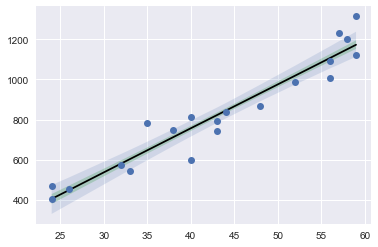

In [167]:
plot_mcmc(la, data_salary['X'], 'y_base', data_salary['X'], data_salary['Y'])

ベイズ予測区間(95%, 50%, 中央値)

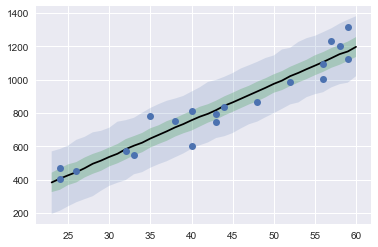

In [168]:
plot_mcmc(la, data_salary['X_new'], 'y_new', data_salary['X'], data_salary['Y'])

## 演習問題

In [169]:
N1 = 30
N2 = 20
Y1 = np.random.normal(0.0, 5.0, N1)
Y2 = np.random.normal(1.0, 4.0, N2)
data_ex_4 = {'N1':N1, 'N2':N2, 'Y1':Y1, 'Y2':Y2}

(1)

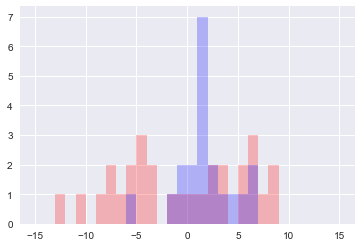

In [170]:
plt.hist(Y1, bins = 30, range = (-15.0, 15.0), color = 'r', alpha = 0.25)
plt.hist(Y2, bins = 30, range = (-15.0, 15.0), color = 'b', alpha = 0.25)
plt.show()

(2)

In [171]:
model_ex_4 = """
data {
  int N1;
  int N2;
  real Y1[N1];
  real Y2[N2];
}

parameters {
  real mu1;
  real mu2;
  real sigma;
}

model {
  for (n in 1:N1)
    Y1[n] ~ normal(mu1, sigma);
  for (n in 1:N2)
    Y2[n] ~ normal(mu2, sigma);
}
"""

(3)

In [172]:
fit = pystan.stan(model_code=model_ex_4, data=data_ex_4, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_55e97837d0c34cb47362ea435639f878 NOW.


In [173]:
print(fit)

Inference for Stan model: anon_model_55e97837d0c34cb47362ea435639f878.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu1    -0.06    0.02   1.06  -2.15  -0.74  -0.07   0.67   1.98   1910    1.0
mu2     1.83    0.03   1.31   -0.7   0.96    1.8   2.67    4.5   1972    1.0
sigma    5.8    0.01    0.6    4.8   5.38   5.73   6.15   7.13   2000    1.0
lp__  -112.0    0.04   1.26 -115.3 -112.6 -111.7 -111.1 -110.6    851   1.01

Samples were drawn using NUTS at Tue Mar 21 15:37:11 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


(4)

In [174]:
la = fit.extract(permuted=True)

In [175]:
c1, c2 = 0,0
for (mu1,mu2) in zip(la['mu1'], la['mu2']):
    if mu1 < mu2:
        c1 += 1
    else:
        c2 += 1
print(c1 / (c1+c2))

0.875


(5)

In [176]:
model_ex_4_a = """
data {
  int N1;
  int N2;
  real Y1[N1];
  real Y2[N2];
}

parameters {
  real mu1;
  real mu2;
  real sigma1;
  real sigma2;
}

model {
  for (n in 1:N1)
    Y1[n] ~ normal(mu1, sigma1);
  for (n in 1:N2)
    Y2[n] ~ normal(mu2, sigma2);
}
"""

In [177]:
fit = pystan.stan(model_code=model_ex_4_a, data=data_ex_4, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_24d439a38e257158f793f74be588819e NOW.


In [178]:
print(fit)
la = fit.extract(permuted=True)

Inference for Stan model: anon_model_24d439a38e257158f793f74be588819e.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu1      0.04    0.03   1.34  -2.58  -0.81   0.01   0.91   2.72   1688    1.0
mu2      1.82    0.02   0.67   0.58   1.37   1.82   2.27   3.12   1719    1.0
sigma1   7.25    0.03   1.06   5.51    6.5   7.14    7.9   9.67   1170    1.0
sigma2   2.95    0.02   0.53   2.15   2.59   2.87   3.23    4.2   1065    1.0
lp__   -104.5    0.06   1.59 -108.4 -105.3 -104.1 -103.3 -102.4    700    1.0

Samples were drawn using NUTS at Tue Mar 21 15:37:32 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [179]:
c1, c2 = 0,0
for (mu1,mu2) in zip(la['mu1'], la['mu2']):
    if mu1 < mu2:
        c1 += 1
    else:
        c2 += 1
print(c1 / (c1+c2))

0.8835
